In [1]:
%load_ext autoreload
%autoreload 2

from glob import glob
import pandas as pd
import os
import mir_eval
from common_jupyter import *
import datasets

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

experiments_dir = "./models/"
class args:
    samplerate = 44100
    hop_length = 1024
    frame_width = hop_length

def get_results(paths, attributes, attr_names):
    instrument_mappings =  {
        1:  {"id": 0, "instrument": "piano"},
        7:  {"id": 1, "instrument": "harpsichord"},
        41: {"id": 2, "instrument": "violin"},
        42: {"id": 3, "instrument": "viola"},
        43: {"id": 4, "instrument": "cello"},
        44: {"id": 5, "instrument": "contrabass"},
        61: {"id": 6, "instrument": "french horn"},
        69: {"id": 7, "instrument": "oboe"},
        71: {"id": 8, "instrument": "bassoon"},
        72: {"id": 9, "instrument": "clarinet"},
        74: {"id": 10, "instrument": "flute"},
    }
    instruments = [m["instrument"] for m in instrument_mappings.values()]
    target_names = [None]*(max([im["id"] for im in instrument_mappings.values()]) + 1)
    for _, im in instrument_mappings.items():
        i = im["id"]
        target_names[i] = im["instrument"]

    dataset = "musicnet_mir"

    results = []
    for path, attrs in zip(paths, attributes):
        est_paths = glob(os.path.join(path, dataset+"*", "*.npy"))
        ref_paths = glob(os.path.join(path, dataset+"*", "reference", "*.npy"))

        attrs_dict = dict(zip(attr_names, attrs))

        ref_matrices = []
        est_matrices = []
        for est_path, ref_path in zip(est_paths, ref_paths):
            ref_matrix = np.load(ref_path)
            est_matrix = np.load(est_path)
            ref_matrices.append(ref_matrix)
            est_matrices.append(est_matrix)

        ref_matrix = np.concatenate(ref_matrices)
        est_matrix = np.concatenate(est_matrices)
        report = sklearn.metrics.classification_report(ref_matrix, est_matrix, target_names=target_names, output_dict=True)
        
        num_nonzero_scores = 0
        my_macro_f1 = 0
        my_macro_p = 0
        my_macro_r = 0
        for instrument, scores in report.items():
            if instrument in instruments and scores["support"] > 0:
                num_nonzero_scores += 1
                my_macro_f1 += scores["f1-score"]
                my_macro_p += scores["precision"]
                my_macro_r += scores["recall"]
        my_macro_f1 /= num_nonzero_scores
        my_macro_p /= num_nonzero_scores
        my_macro_r /= num_nonzero_scores

        scores = {
            "micro_f1": report["micro avg"]["f1-score"],
            "micro_precision": report["micro avg"]["precision"],
            "micro_recall": report["micro avg"]["recall"],
            "macro_f1": my_macro_f1,
            "macro_precision": my_macro_p,
            "macro_recall": my_macro_r,
        }

        result = {**scores, **attrs_dict, "Path": path, "Est_path": est_path}
        if "parameters" not in result:
            parameters = get_param_num(path)
            result["parameters"] = parameters
        print(".", end="")
        results.append(result)
    return pd.DataFrame(results)

/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jirka/miniconda3/envs/melody/lib/python3

In [2]:
#-mir-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f32-s8-us1-os5-su7-cc1-lck1,72-lpavg-rh2-b1-d0.0
attr_names = ["hconv_inside"]
attr_types = [str, int, str, int]
regex = "mir-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f\d+-s8-(us1-os5|us0-os1)-su7-cc1-lck1,72-lpavg-rh2-b1-d0.0"
experiments_paths = get_paths(experiments_dir, results_dir="model-mir-outputs")
paths = list(filter(lambda x: re.search(regex, x), experiments_paths))
attributes = get_attrs_from_paths(regex, attr_types, paths)

In [4]:
all_data = get_results(paths, attributes, attr_names)
all_data.hconv_inside = all_data.hconv_inside.map({"us0-os1":"no", "us1-os5": "yes"})

/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true

.......

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one metagraph event per run. Overwriting the metagraph with the newest event.


...

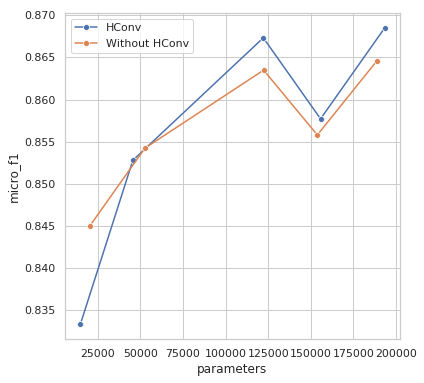

In [5]:
sns.set(rc={'figure.figsize': (6, 6)})
sns.set(style="whitegrid")


sns.lineplot(x="parameters", y="micro_f1", marker="o", data=all_data[all_data.hconv_inside=="yes"], label="HConv")
sns.lineplot(x="parameters", y="micro_f1", marker="o", data=all_data[all_data.hconv_inside=="no"], label="Without HConv")

#plt.ylim(0.83, 0.86)

In [30]:
# 0506_110739-mir-bs16-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f16-s8-us0-os1-cc1,1,1-lck1,1-lpglobalavg-rh2-b1-d0.0
experiments_dir = "./models-mir/"
attr_names = ["hconv_inside", "p"]
attr_types = [str, str]
regex = "mir-bs16-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f\d+-s8(-us0-os1|-us1-os5)-cc1,1,1-lck1,1-lpglobalavg-rh2-b1-d0.0(-p(\d+))?"
experiments_paths = get_paths(experiments_dir, results_dir="model-mir-outputs")
paths = list(filter(lambda x: re.search(regex, x), experiments_paths))
attributes = get_attrs_from_paths(regex, attr_types, paths)
assert len(paths) != 0
paths

['./models-mir/0506_110739-mir-bs16-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f16-s8-us0-os1-cc1,1,1-lck1,1-lpglobalavg-rh2-b1-d0.0-p6235/model-mir-outputs',
 './models-mir/0506_123846-mir-bs16-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f8-s8-us0-os1-cc1,1,1-lck1,1-lpglobalavg-rh2-b1-d0.0-p1779/model-mir-outputs',
 './models-mir/0506_133309-mir-bs16-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f32-s8-us0-os1-cc1,1,1-lck1,1-lpglobalavg-rh2-b1-d0.0-p23211/model-mir-outputs',
 './models-mir/0506_143511-mir-bs16-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f64-s8-us0-os1-cc1,1,1-lck1,1-lpglobalavg-rh2-b1-d0.0-p89419/model-mir-outputs',
 './models-mir/0506_163259-mir-bs16-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f48-s8-us0-os1-cc1,1,1-lck1,1-lpglobalavg-rh2-b1-d0.0-p50939/model-mir-outputs',
 './models-mir/0506_181800-mir-bs16-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f80-s8-us0-os1-cc1,1,1-lck1,1-lpglobalavg-rh2-b1-d0.0-p138651/model-mir-outputs',
 './models-mir/0506_212344-mir-bs16-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f32-s

In [31]:
all_data_2 = get_results(paths, attributes, attr_names)
all_data_2.hconv_inside = all_data_2.hconv_inside.map({"-us0-os1":"no", "-us1-os5": "yes"})

.............

In [32]:
all_data_2

,Est_path,Path,hconv_inside,macro_f1,macro_precision,macro_recall,micro_f1,micro_precision,micro_recall,p,parameters
0,./models-mir/0506_110739-mir-bs16-fw1024-cw0-s...,./models-mir/0506_110739-mir-bs16-fw1024-cw0-s...,no,0.766482,0.689848,0.878075,0.801532,0.715179,0.911600,-p6235,6235
1,./models-mir/0506_123846-mir-bs16-fw1024-cw0-s...,./models-mir/0506_123846-mir-bs16-fw1024-cw0-s...,no,0.694451,0.623867,0.819242,0.728197,0.629650,0.863314,-p1779,1779
2,./models-mir/0506_133309-mir-bs16-fw1024-cw0-s...,./models-mir/0506_133309-mir-bs16-fw1024-cw0-s...,no,0.787491,0.698827,0.914506,0.825653,0.736669,0.939087,-p23211,23211
3,./models-mir/0506_143511-mir-bs16-fw1024-cw0-s...,./models-mir/0506_143511-mir-bs16-fw1024-cw0-s...,no,0.801136,0.708291,0.932388,0.836801,0.746117,0.952579,-p89419,89419
4,./models-mir/0506_163259-mir-bs16-fw1024-cw0-s...,./models-mir/0506_163259-mir-bs16-fw1024-cw0-s...,no,0.800747,0.710859,0.927823,0.838920,0.751774,0.948920,-p50939,50939
5,./models-mir/0506_181800-mir-bs16-fw1024-cw0-s...,./models-mir/0506_181800-mir-bs16-fw1024-cw0-s...,no,0.807143,0.713532,0.940355,0.844476,0.756097,0.956250,-p138651,138651
6,./models-mir/0506_212344-mir-bs16-fw1024-cw0-s...,./models-mir/0506_212344-mir-bs16-fw1024-cw0-s...,no,0.787704,0.695425,0.920925,0.824315,0.732785,0.941975,-p23211,23211
7,./models-mir/0507_024508-mir-bs16-fw1024-cw0-s...,./models-mir/0507_024508-mir-bs16-fw1024-cw0-s...,yes,0.823993,0.731019,0.955380,0.856464,0.770018,0.964773,-p132491,132491
8,./models-mir/0515_231856-mir-bs16-fw1024-cw0-s...,./models-mir/0515_231856-mir-bs16-fw1024-cw0-s...,no,0.746032,0.716713,0.783524,0.851035,0.808071,0.898824,,198635
9,./models-mir/0516_000006-mir-bs16-fw1024-cw0-s...,./models-mir/0516_000006-mir-bs16-fw1024-cw0-s...,yes,0.777685,0.738290,0.828087,0.866677,0.819662,0.919415,,205931


(0.8, 0.87)

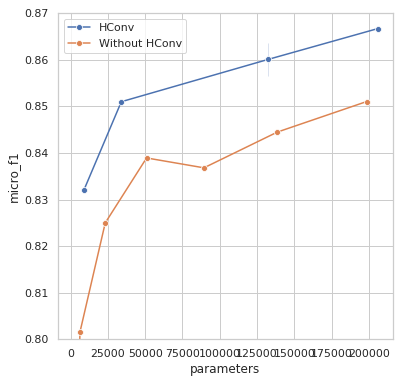

In [33]:
sns.set(rc={'figure.figsize': (6, 6)})
sns.set(style="whitegrid")


sns.lineplot(x="parameters", y="micro_f1", marker="o", data=all_data_2[all_data_2.hconv_inside=="yes"], label="HConv")
sns.lineplot(x="parameters", y="micro_f1", marker="o", data=all_data_2[all_data_2.hconv_inside=="no"], label="Without HConv")

plt.ylim(0.8, 0.87)

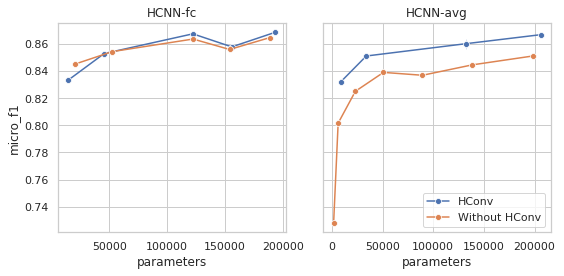

In [34]:
# both plots in one figure
sns.set(rc={'figure.figsize': (8, 4)})
sns.set(style="whitegrid")
fig, axs = plt.subplots(1,2, sharey=True)

#sns.lineplot(ax=axs[0], x="parameters", y="F1", marker="o", data=convnet[convnet.hconv_inside=="yes"], label="HConv")
#sns.lineplot(ax=axs[0], x="parameters", y="F1", marker="o", data=convnet[(convnet.hconv_input=="yes") & (convnet.hconv_inside=="no")], label="HConv only input")
#ax = sns.lineplot(ax=axs[0], x="parameters", y="F1", marker="o", data=convnet[convnet.hconv_input=="no"], label="Without HConv")
#ax.get_legend().set_visible(False)
#ax.set_title("ConvNet")
metric = "micro_f1"

sns.lineplot(ax=axs[0], x="parameters", y=metric, marker="o", data=all_data[all_data.hconv_inside=="yes"], label="HConv")
sns.lineplot(ax=axs[0], x="parameters", y=metric, marker="o", data=all_data[all_data.hconv_inside=="no"], label="Without HConv")
axs[0].get_legend().set_visible(False)
axs[0].set_title("HCNN-fc")


sns.lineplot(ax=axs[1], x="parameters", y=metric, marker="o", data=all_data_2[all_data_2.hconv_inside=="yes"], label="HConv")
sns.lineplot(ax=axs[1], x="parameters", y=metric, marker="o", data=all_data_2[all_data_2.hconv_inside=="no"], label="Without HConv")
axs[1].set_title("HCNN-avg")

plt.tight_layout()

#plt.ylim(0.63, 0.73)

plt.savefig("comparison_instrument_recognition.pdf")

In [44]:
# 0507_134434-mir-bs16-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f32-s8-us2-os1-cc1,1,1-lck1,1-lpglobalavg-rh2-b1-d0.0-p66923
attr_names = ["hconv_under", "hconv_over", "parameters"]
attr_types = [int, int, int]
regex = "mir-bs16-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f32-s8-us(\d+)-os(\d+)-cc1,1,1-lck1,1-lpglobalavg-rh2-b1-d0.0-p(\d+)"
experiments_paths = get_paths(experiments_dir, results_dir="model-mir-outputs")
paths = list(filter(lambda x: re.search(regex, x), experiments_paths))
attributes = get_attrs_from_paths(regex, attr_types, paths)

In [46]:
all_data = get_results(paths, attributes, attr_names)
#all_data.hconv_inside = all_data.hconv_inside.map({"-us0-os1":"no", "-us0-os4": "yes"})
all_data["pomer"] = all_data.micro_f1 / all_data.parameters
all_data.sort_values(by=["macro_f1"])

#sns.set(rc={'figure.figsize': (6, 6)})
#sns.set(style="whitegrid")


#sns.lineplot(x="parameters", y="micro_f1", marker="o", data=all_data, label="HConv")


/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/home/jirka/miniconda3/envs/melody/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

................

,Est_path,Path,hconv_over,hconv_under,macro_f1,macro_precision,macro_recall,micro_f1,micro_precision,micro_recall,parameters,pomer
0,./models-mir/0506_133309-mir-bs16-fw1024-cw0-s...,./models-mir/0506_133309-mir-bs16-fw1024-cw0-s...,1,0,0.787491,0.698827,0.914506,0.825653,0.736669,0.939087,23211,0.000036
2,./models-mir/0506_212344-mir-bs16-fw1024-cw0-s...,./models-mir/0506_212344-mir-bs16-fw1024-cw0-s...,1,0,0.787704,0.695425,0.920925,0.824315,0.732785,0.941975,23211,0.000036
7,./models-mir/0507_003050-mir-bs16-fw1024-cw0-s...,./models-mir/0507_003050-mir-bs16-fw1024-cw0-s...,1,1,0.805989,0.712282,0.938793,0.839385,0.748361,0.955619,45067,0.000019
3,./models-mir/0506_215011-mir-bs16-fw1024-cw0-s...,./models-mir/0506_215011-mir-bs16-fw1024-cw0-s...,2,0,0.806728,0.715405,0.935979,0.842453,0.755910,0.951375,45067,0.000019
8,./models-mir/0507_010003-mir-bs16-fw1024-cw0-s...,./models-mir/0507_010003-mir-bs16-fw1024-cw0-s...,2,1,0.808986,0.714936,0.943734,0.842574,0.752301,0.957466,66923,0.000013
12,./models-mir/0507_134434-mir-bs16-fw1024-cw0-s...,./models-mir/0507_134434-mir-bs16-fw1024-cw0-s...,1,2,0.816140,0.722273,0.948549,0.847673,0.757313,0.962517,66923,0.000013
6,./models-mir/0506_235143-mir-bs16-fw1024-cw0-s...,./models-mir/0506_235143-mir-bs16-fw1024-cw0-s...,5,0,0.816431,0.723658,0.948550,0.849947,0.761830,0.961114,110635,0.000008
4,./models-mir/0506_222000-mir-bs16-fw1024-cw0-s...,./models-mir/0506_222000-mir-bs16-fw1024-cw0-s...,3,0,0.817857,0.725126,0.949545,0.850490,0.762107,0.962061,66923,0.000013
1,./models-mir/0506_135944-mir-bs16-fw1024-cw0-s...,./models-mir/0506_135944-mir-bs16-fw1024-cw0-s...,4,0,0.818218,0.726222,0.946887,0.852207,0.765062,0.961757,88779,0.000010
10,./models-mir/0507_020709-mir-bs16-fw1024-cw0-s...,./models-mir/0507_020709-mir-bs16-fw1024-cw0-s...,4,1,0.818246,0.719629,0.960978,0.851407,0.758848,0.969684,110635,0.000008


In [87]:
# 0513_055630-mir-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f4-s8-us0-os1-cc1-lck1,72-lpavg-rh2-b1-d0.0
attr_names = ["hconv_over"]
attr_types = [int, int, int]
regex = "mir-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f\d+-s8-us0-os(\d)-cc1-lck1,72-lpavg-rh2-b1-d0.0"
experiments_paths = get_paths(experiments_dir, results_dir="model-mir-outputs")
paths = list(filter(lambda x: re.search(regex, x), experiments_paths))
attributes = get_attrs_from_paths(regex, attr_types, paths)

In [88]:
all_data = get_results(paths, attributes, attr_names)
#all_data["pomer"] = all_data.f1 / all_data.parameters
#all_data.sort_values(by=["pomer"])

...........

In [91]:
paths

['./models/0513_055630-mir-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f4-s8-us0-os1-cc1-lck1,72-lpavg-rh2-b1-d0.0/model-mir-outputs',
 './models/0513_062836-mir-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f12-s8-us0-os3-cc1-lck1,72-lpavg-rh2-b1-d0.0/model-mir-outputs',
 './models/0513_070136-mir-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f8-s8-us0-os1-cc1-lck1,72-lpavg-rh2-b1-d0.0/model-mir-outputs',
 './models/0513_073319-mir-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f24-s8-us0-os3-cc1-lck1,72-lpavg-rh2-b1-d0.0/model-mir-outputs',
 './models/0513_081047-mir-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f16-s8-us0-os1-cc1-lck1,72-lpavg-rh2-b1-d0.0/model-mir-outputs',
 './models/0513_084259-mir-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f48-s8-us0-os3-cc1-lck1,72-lpavg-rh2-b1-d0.0/model-mir-outputs',
 './models/0513_095215-mir-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f32-s8-us0-os1-cc1-lck1,72-lpavg-rh2-b1-d0.0/model-mir-outputs',
 './models/0513_102436-mir-fw1024-cw0-scqt-sus1-sos5-adeep_hcnn-f96-s8-us0-os3-cc1-lck1,72-lpavg-rh

In [89]:
all_data["hconv_inside"] = all_data.hconv_over.map({1:"no", 3: "yes"})

all_data

,Est_path,Path,f1,hconv_over,parameters,hconv_inside
0,./models/0513_055630-mir-fw1024-cw0-scqt-sus1-...,./models/0513_055630-mir-fw1024-cw0-scqt-sus1-...,0.783578,1,3683,no
1,./models/0513_062836-mir-fw1024-cw0-scqt-sus1-...,./models/0513_062836-mir-fw1024-cw0-scqt-sus1-...,0.841517,3,38099,yes
2,./models/0513_070136-mir-fw1024-cw0-scqt-sus1-...,./models/0513_070136-mir-fw1024-cw0-scqt-sus1-...,0.831526,1,8027,no
3,./models/0513_073319-mir-fw1024-cw0-scqt-sus1-...,./models/0513_073319-mir-fw1024-cw0-scqt-sus1-...,0.851875,3,94331,yes
4,./models/0513_081047-mir-fw1024-cw0-scqt-sus1-...,./models/0513_081047-mir-fw1024-cw0-scqt-sus1-...,0.837827,1,18731,no
5,./models/0513_084259-mir-fw1024-cw0-scqt-sus1-...,./models/0513_084259-mir-fw1024-cw0-scqt-sus1-...,0.860133,3,261227,yes
6,./models/0513_095215-mir-fw1024-cw0-scqt-sus1-...,./models/0513_095215-mir-fw1024-cw0-scqt-sus1-...,0.855317,1,48203,no
7,./models/0513_102436-mir-fw1024-cw0-scqt-sus1-...,./models/0513_102436-mir-fw1024-cw0-scqt-sus1-...,0.861190,3,812747,yes
8,./models/0513_125014-mir-fw1024-cw0-scqt-sus1-...,./models/0513_125014-mir-fw1024-cw0-scqt-sus1-...,0.857715,1,88427,no
9,./models/0513_133131-mir-fw1024-cw0-scqt-sus1-...,./models/0513_133131-mir-fw1024-cw0-scqt-sus1-...,0.855525,1,139403,no


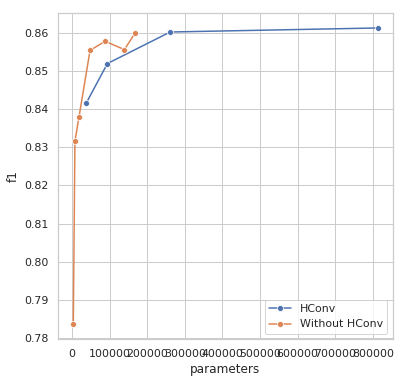

In [90]:
sns.set(rc={'figure.figsize': (6, 6)})
sns.set(style="whitegrid")


sns.lineplot(x="parameters", y="f1", marker="o", data=all_data[all_data.hconv_inside=="yes"], label="HConv")
sns.lineplot(x="parameters", y="f1", marker="o", data=all_data[all_data.hconv_inside=="no"], label="Without HConv")

#plt.ylim(0.8, 0.86)